# Дипломный проект

Студент Бабкина О.С.

Для данной работы использовались следующие данные: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

Данные датасета были выгружены из твиттера и вручную размечены. Названия аккаунтов и имена пользователей были закодированы. Основная информация разбита на следующие колонки:

1) "Location" - Местоположение
2) "TweetAt" - Дата твита
3) "OriginalTweet" - Текст твита
4) "Sentiment" - Эмоциональная окраска твита

Данный датасет разбит на два: тренировочный и тестовый. 

Задача: произвести классификацию твитов по эмоциональной окраске(целевая переменная - Sentiment)

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import emoji
import string

import tensorflow as tf

import tensorflow as tf

from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


from transformers import BertTokenizerFast
from transformers import TFBertModel

# Переменная для определения, частоту скольких первых слов отобразить на графике
most_common_words = 20  

#максимальное количество слов в твите
TEXT_MAX_LEN = 512

RANDOM_STATE = 42

D:\Olya_work\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

Загрузим датасет

In [3]:
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')

df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

Выведем общую информацию, а так же первые несколько строчек для тренировочного и тестового датасета

In [4]:
print(df_train.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
print(df_test.info())
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB
None


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Как видим, в обоих датасета присутствуют пропуски в строке "Location", выведем тепловую карту для пропусков в обоих датасетах

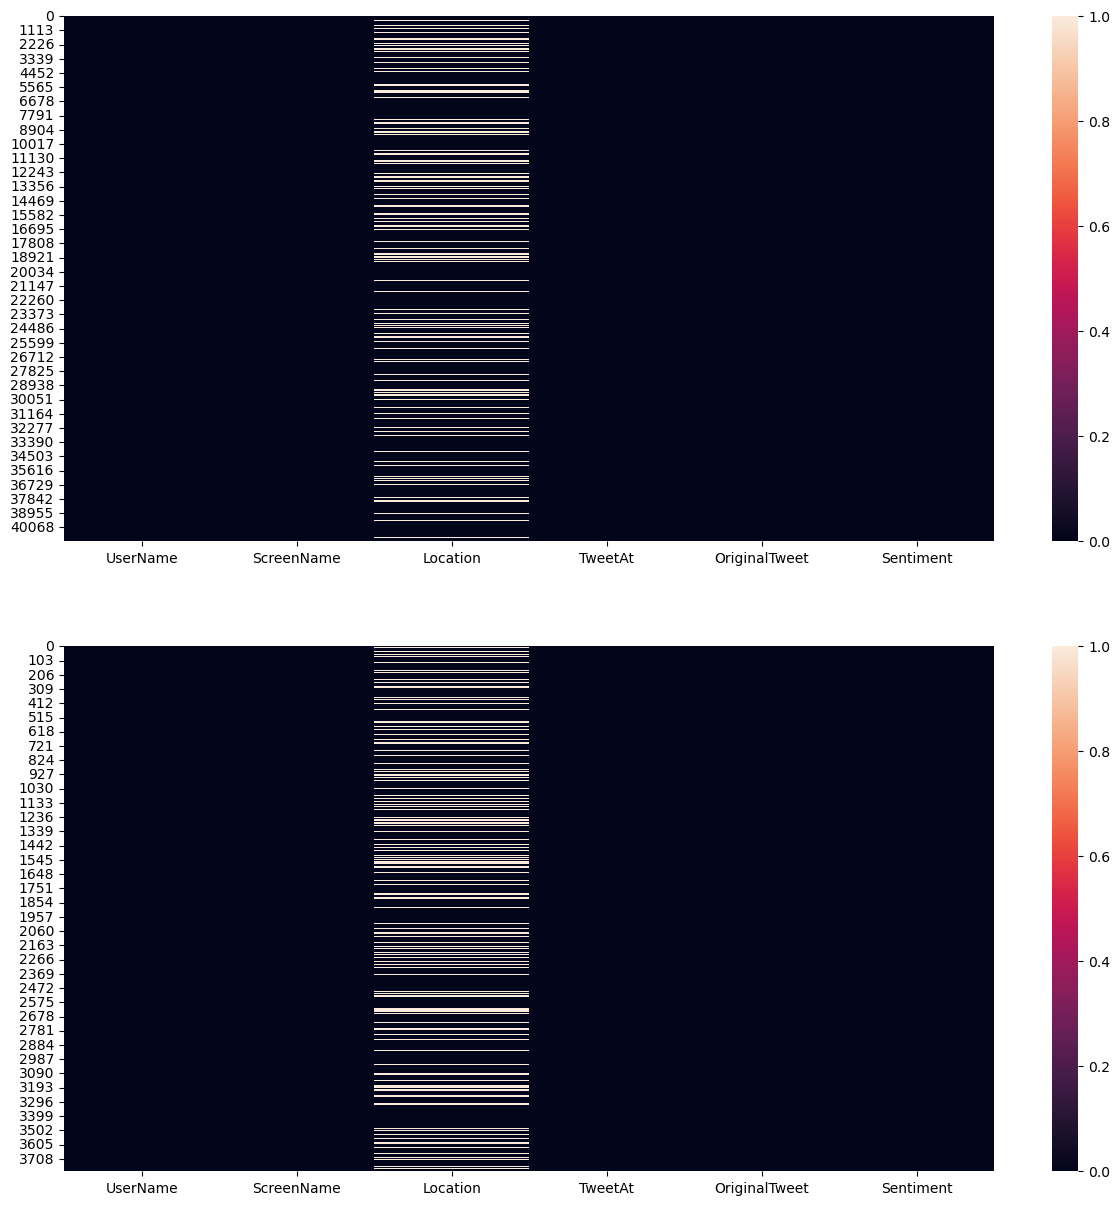

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

for i,d in enumerate([df_train.isnull(), df_test.isnull()]):
    sns.heatmap(d, ax=ax[i])

Как видим, пропуски занимают большая часть столбца Location не заполнена. Удалим всем пропуски, а так же дубликаты в обоих датасетах, также удалим первый столбец в обоих датасетах, обоначающий порядковый номер строки

In [7]:
#удаление дубликатов и пропусков для тренировочного датасета
df_train.drop_duplicates(inplace = True)
df_train.dropna(inplace= True)

#для тестового датасета
df_test.drop_duplicates(inplace = True)
df_test.dropna(inplace = True)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       32567 non-null  int64 
 1   ScreenName     32567 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        32567 non-null  object
 4   OriginalTweet  32567 non-null  object
 5   Sentiment      32567 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.7+ MB


Как видим, теперь в датасете отсутствуют пропуски. Проведем анализ очищенных от пропусков данных. 

## Анализ данных

Для начала проанализируем целевую переменную(столбец Sentiment)

In [9]:
print(df_train.Sentiment.value_counts())

Positive              9110
Negative              7763
Neutral               6172
Extremely Positive    5273
Extremely Negative    4249
Name: Sentiment, dtype: int64


In [10]:
def pie(percent_class, labels, radius = 1.0):
    colors = ['#17C37B','#F92969','#FACA0C']
   
    my_pie,_,_ = plt.pie(percent_class, radius = radius, labels=labels,colors=colors,autopct="%.1f%%")
    plt.setp(my_pie, width=0.6, edgecolor='white') 
    plt.show()

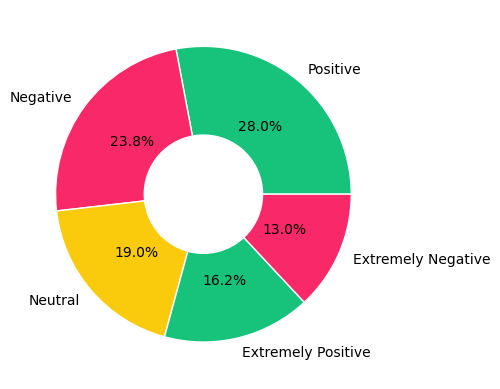

In [11]:
target_class = df_train['Sentiment'].value_counts(normalize= True)
percent_class = target_class.values
labels = target_class.index

pie(percent_class, labels)

Как видим проценты каждого из классов целевой переменной примерно равны. Для упрощения предсказания будем считать твиты, объеденим классы Extremely Negative и Negative, а так же Extremely Positive и Positive

C:\Users\User\AppData\Local\Temp\ipykernel_11268\3813941847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Negative'] = 'Negative'
C:\Users\User\AppData\Local\Temp\ipykernel_11268\3813941847.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Positive'] = 'Positive'


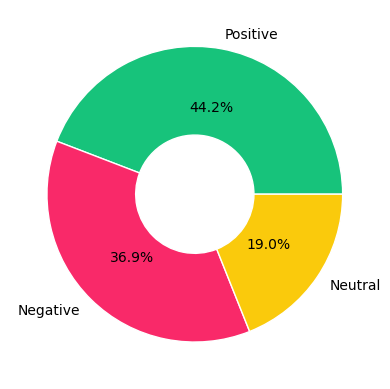

In [12]:
df_clean_train = df_train.copy(deep = True)

df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Negative'] = 'Negative'
df_clean_train['Sentiment'].loc[df_clean_train['Sentiment'] == 'Extremely Positive'] = 'Positive'

target_class = df_clean_train['Sentiment'].value_counts(normalize= True)
percent_class = target_class.values
labels = target_class.index

pie(target_class, labels)

Как видим, в тренировочном датасете преобладают позитивные твиты, однако по-настоящему больших перевесов ни один из классов не имеет. Проанализируем аналогично тестовую выборку.

C:\Users\User\AppData\Local\Temp\ipykernel_11268\1754952420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Negative'] = 'Negative'
C:\Users\User\AppData\Local\Temp\ipykernel_11268\1754952420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Positive'] = 'Positive'


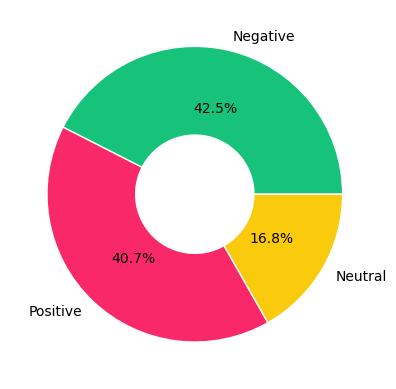

In [13]:
df_clean_test = df_test.copy(deep = True)

df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Negative'] = 'Negative'
df_clean_test['Sentiment'].loc[df_test['Sentiment'] == 'Extremely Positive'] = 'Positive'

target_class = df_clean_test['Sentiment'].value_counts(normalize= True)
percent_class = target_class.values
labels = target_class.index

pie(target_class, labels)

В тестовом же датасете больше преобладают негативные отзывы, однако, так же как и  трениовочной выборке большого перевеса ни в одном из классов нет. Считаем наши классы в тренировочной и тестовой выборках сбалансированными. 

Проанализируем колонку "OriginalTweet"

<Axes: title={'center': 'Наиболее часто встречающиеся хештеги'}, xlabel='Hashtag', ylabel='count'>

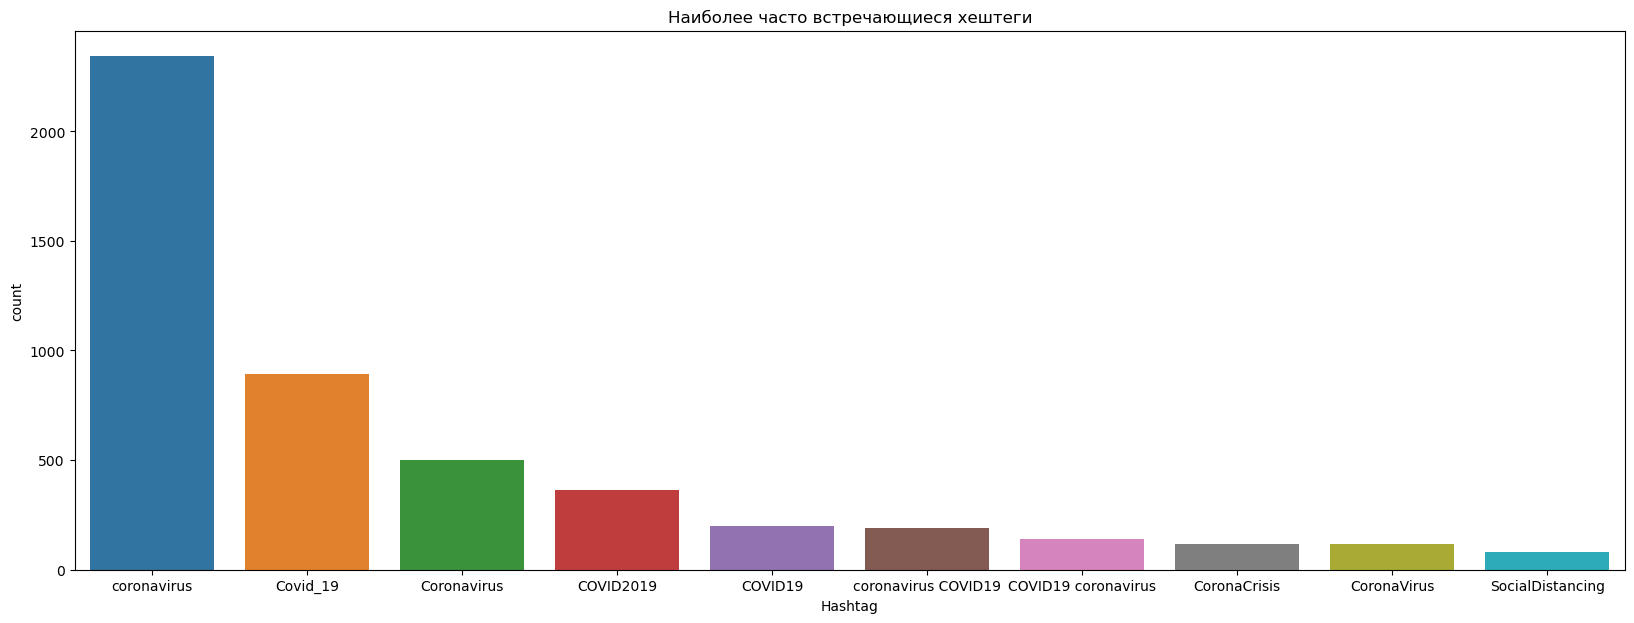

In [14]:
#в данном датасете многин твиты сосотоят из хештегов, посмотрим наиболее встречающееся из них
#для этого объедими тренировочный и тестовый датасет в один
df_combined=pd.concat([df_train, df_test])

def find_hash(tweet):
    line = re.findall(r'(?<=#)\w+', tweet)
    return " ".join(line)

df_combined['hash']=df_combined['OriginalTweet'].apply(lambda x:find_hash(x))

#выведем первые десять наиболее часто встречающиеся хештеги
freaq_hashtag = df_combined['hash'].value_counts()[:][1:11]
freaq_hashtag = freaq_hashtag .to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})

plt.figure(figsize=(20, 7))
plt.title('Наиболее часто встречающиеся хештеги')
sns.barplot(x="Hashtag",y="count", data = freaq_hashtag)

Как видим, хештеги полностью соответствуют теме самого датасета. 

Проанализируем наиболее часто встречающиеся упоминания

<Axes: title={'center': 'Наиболее часто встречающиеся упоминания'}, xlabel='Mentions', ylabel='count'>

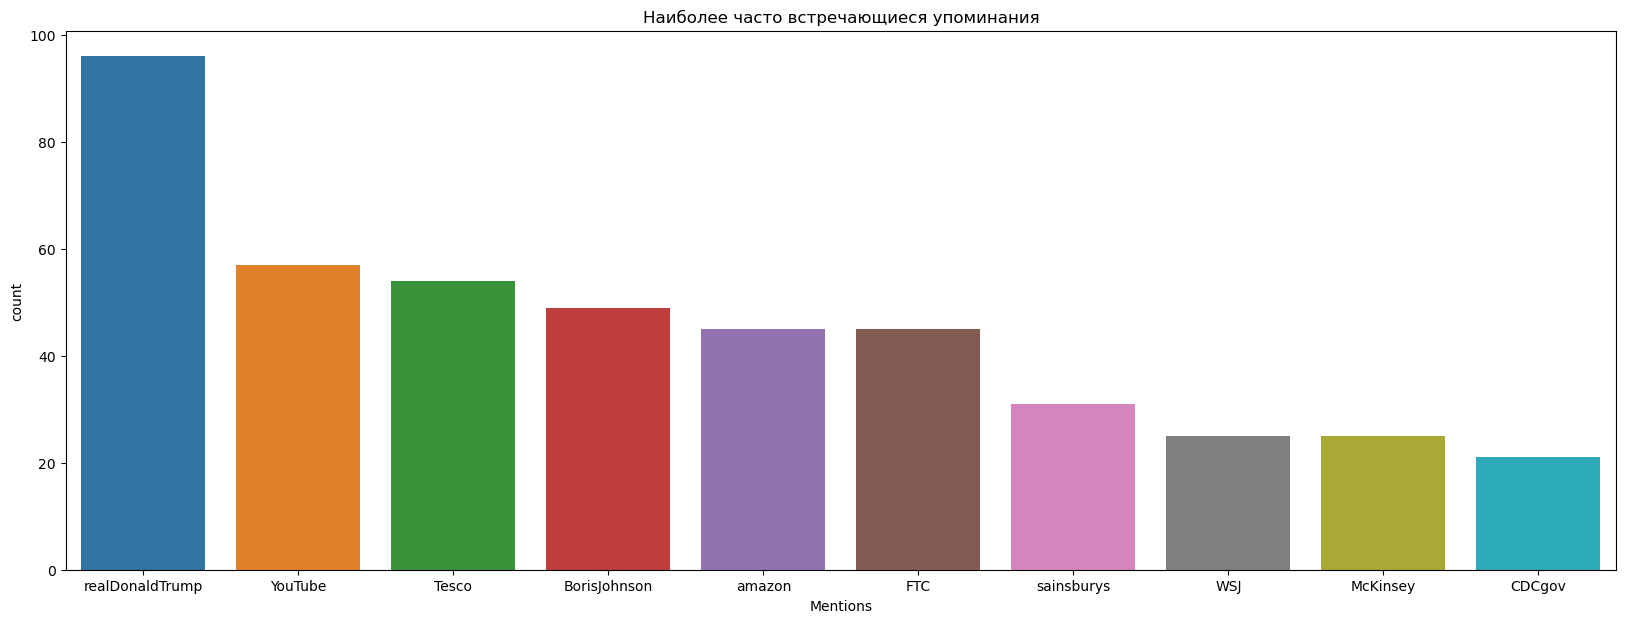

In [15]:
def mentions(tweet):
    line = re.findall(r'(?<=@)\w+',tweet)
    return " ".join(line)

df_combined['mentions'] = df_combined['OriginalTweet'].apply(lambda x:mentions(x))

#выведем первые десять наиболее часто встречающиеся хештеги
freaq_mention = df_combined['mentions'].value_counts()[:][1:11]
freaq_mention = freaq_mention.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

plt.figure(figsize=(20, 7))
plt.title('Наиболее часто встречающиеся упоминания')
sns.barplot(x="Mentions",y="count", data = freaq_mention)

А здесь уже интереснее. Больше всего в данном датасете упоминали английских и американских политиков(Трам и Джонсон), а так же магазины и связанные с ними компании(Tesco, Amason, FTC, sainsburys) и газеты. Из этого можно сделать вывод, что большинство пользователей в данном датасете живут в Великобритании или США. Проверим, проанализировав столбец "Location" 

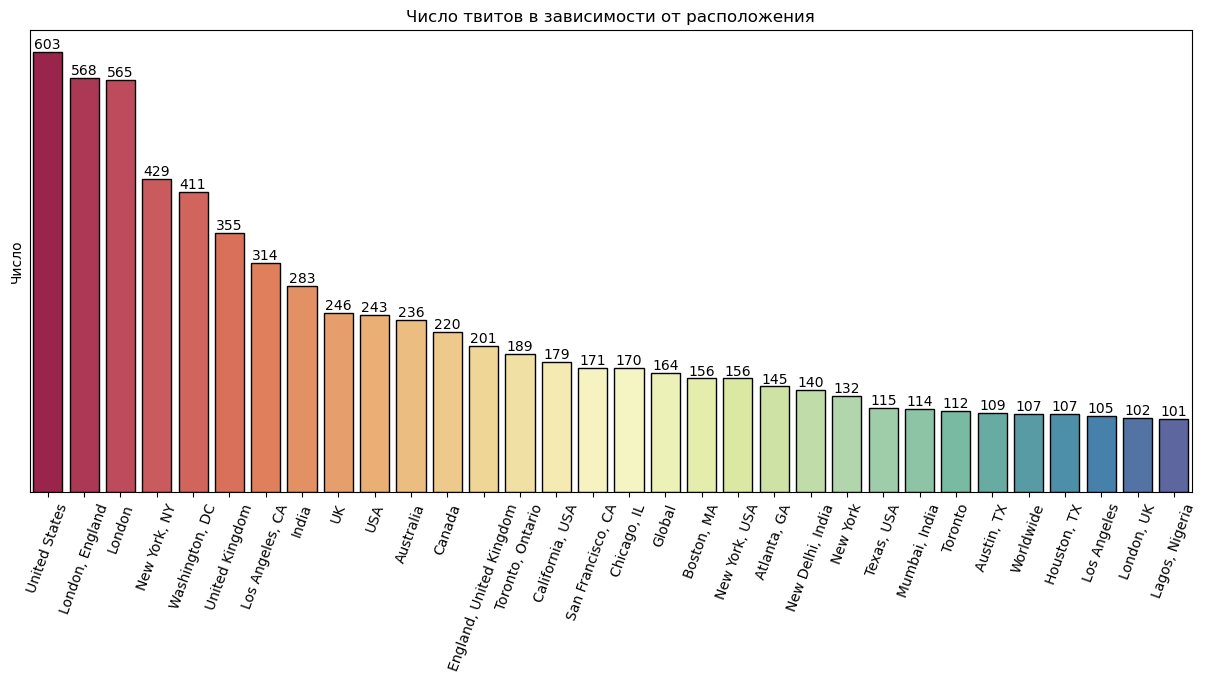

In [16]:
tweets_per_country = df_combined['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black', errorbar=('ci', False), palette='Spectral')
plt.title('Число твитов в зависимости от расположения')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число')
plt.xlabel('')
plt.show()

Как видим, действительно, большиснтво пользователей датасета являются жителями США и Великобритании

## Очистка данных и их анализ

Зададим функцию, которая будет очищать текст твита от "мусорных" символов и стопслов

In [17]:
def clean_data(tweet):
    #приводим к нижнему регистру
    tweet = tweet.lower() 
    #убираем ссылки, знаки препинания и прочие символы
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet) 
    tweet = ''.join (c for c in tweet if c not in string.digits)  #убираем все символы, которые относятся к цифрам
    #убираем эмодзи, знаки пунктуации
    tweet = ' '.join(c for c in tweet.split() if emoji.is_emoji(c)==False  
                                    and c not in string.punctuation)
    tweet = tweet.replace("#", "").replace("_", " ").replace("pm","") 
    return tweet

Очистим тренировочный и тестовый датасет

In [18]:
df_clean_train['CleanedTweet'] = df_clean_train['OriginalTweet'].apply(lambda x:clean_data(x))

df_clean_test['CleanedTweet'] = df_clean_test['OriginalTweet'].apply(lambda x:clean_data(x))

Посмотрим на количество слов, оставшееся в твитах тренировочного датасета после очистки данных

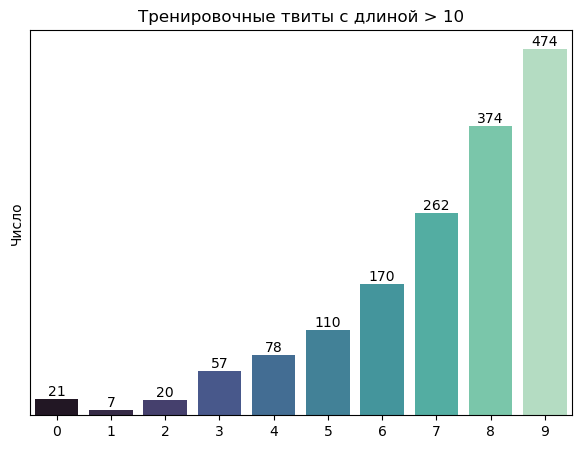

In [19]:
train_text_len = []
for text in df_clean_train['CleanedTweet']:
    tweet_len = len(text.split())
    train_text_len.append(tweet_len)
    
df_clean_train['text_len'] = train_text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_clean_train[df_clean_train['text_len']<10], palette='mako')
plt.title('Тренировочные твиты с длиной > 10')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число')
plt.xlabel('')
plt.show()

Аналогично посмотрим для тестового датасета

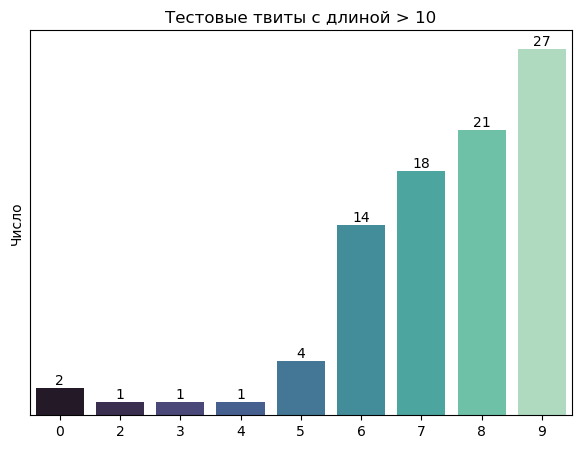

In [20]:
test_text_len = []
for text in df_clean_test['CleanedTweet']:
    tweet_len = len(text.split())
    test_text_len.append(tweet_len)
    
df_clean_test['text_len'] = test_text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_clean_test[df_clean_test['text_len']<10], palette='mako')
plt.title('Тестовые твиты с длиной > 10')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Число')
plt.xlabel('')
plt.show()

Как видно из графиков, в обоих датасетах присутствуют твиты, в которых после очистки данных или совсем не осталось слов(21 в тренировочном наборе и 2 в тестовом), или осталось менее трех слов(27 в в тренировочном наборе и 1 в тестовом). Для обучения будем использовать только те, в которых есть хотя бы 4 слова.

In [21]:
#для тренировочной выборки
df_clean_train = df_clean_train[df_clean_train['text_len'] > 3]

#для тестовой выборки
df_clean_test = df_clean_test[df_clean_test['text_len'] > 3]

Теперь, когда текст твитов очищен от мусорных элементов, проанализируем сам текст

In [22]:
#объеденим уже очищенные тренировочную и тестовую выборки
df_cleaned_combined = pd.concat([df_clean_train, df_clean_test])

Выведем самые часто встречающиеся слова по каждому из настроений

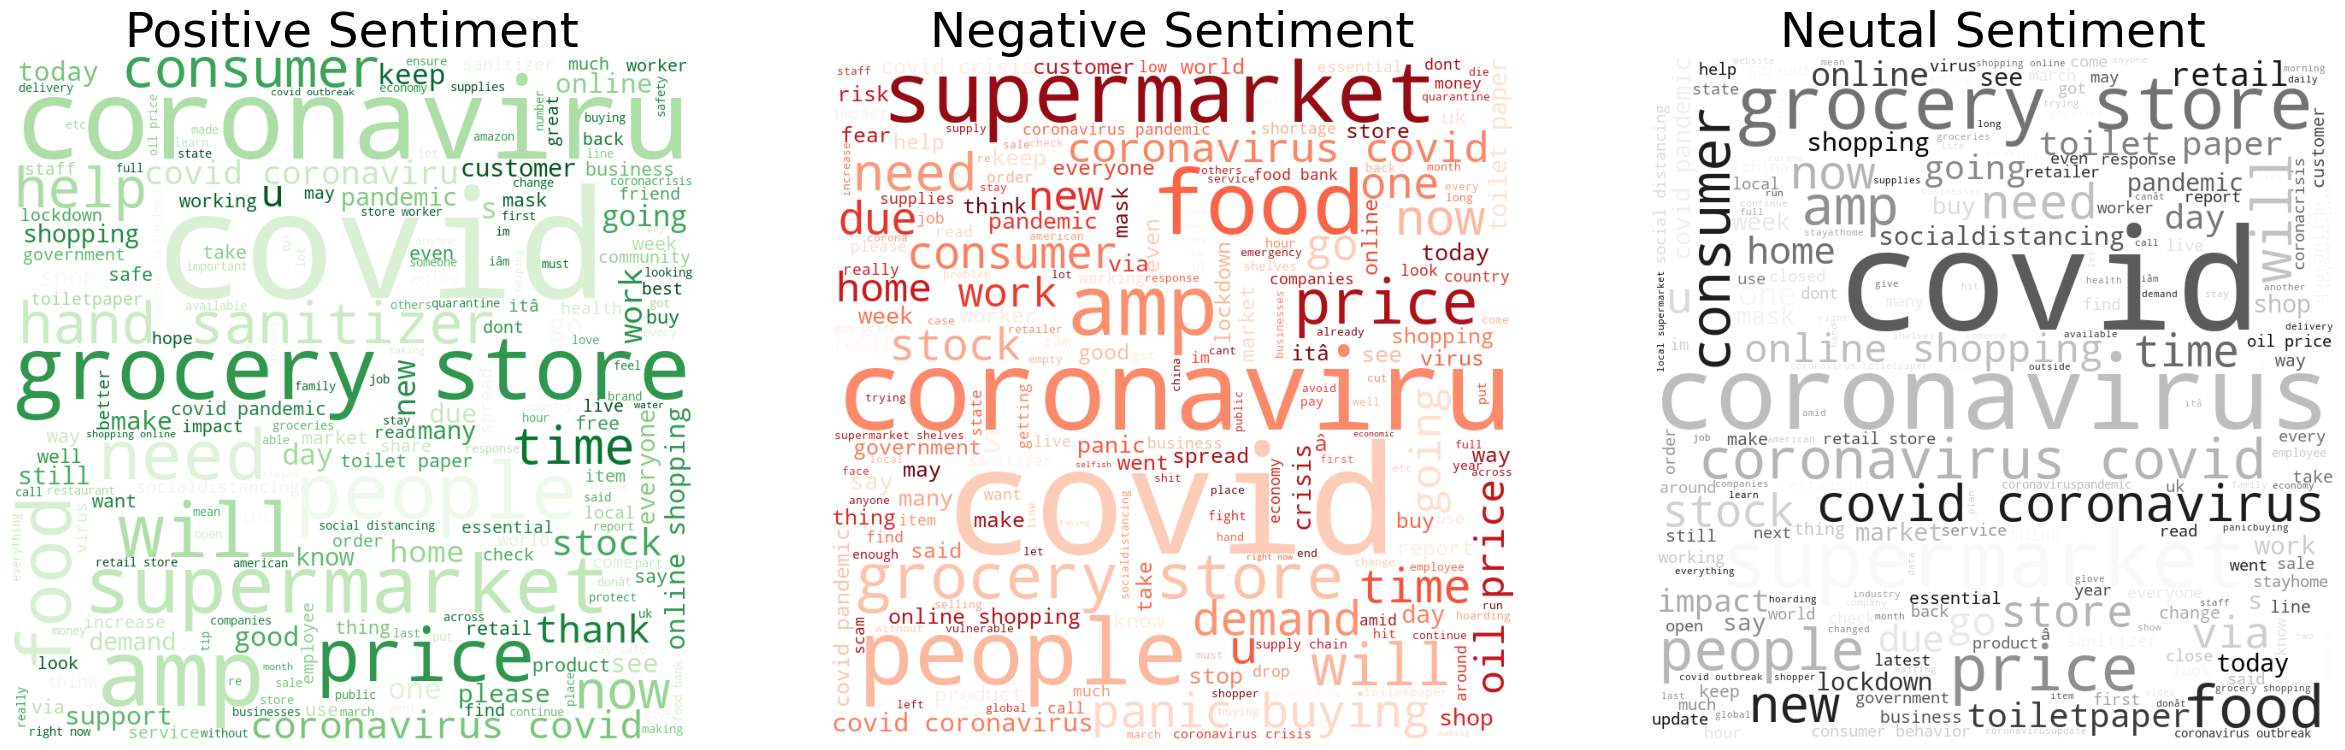

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df_cleaned_combined[df_cleaned_combined["Sentiment"]=="Positive"]
df_neg = df_cleaned_combined[df_cleaned_combined["Sentiment"]=="Negative"]
df_neu = df_cleaned_combined[df_cleaned_combined["Sentiment"]=="Neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for txt in df_pos['CleanedTweet'].values: 
    tokens = txt.split() 
    comment_words += " ".join(tokens)+" "
    
    
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for txt in df_neg['CleanedTweet'].values: 
    tokens = txt.split()      
    comment_words += " ".join(tokens)+" "

wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for txt in df_neu['CleanedTweet'].values: 
    tokens = txt.split()      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

Так же выведем частоту встречающихся слов по твитам в зависимости от эмоциональной окраске, а так же общую частоту встречаемости слов

<Axes: title={'center': 'Общая частота встречаемости слов в датасете'}, xlabel='Слово', ylabel='Word'>

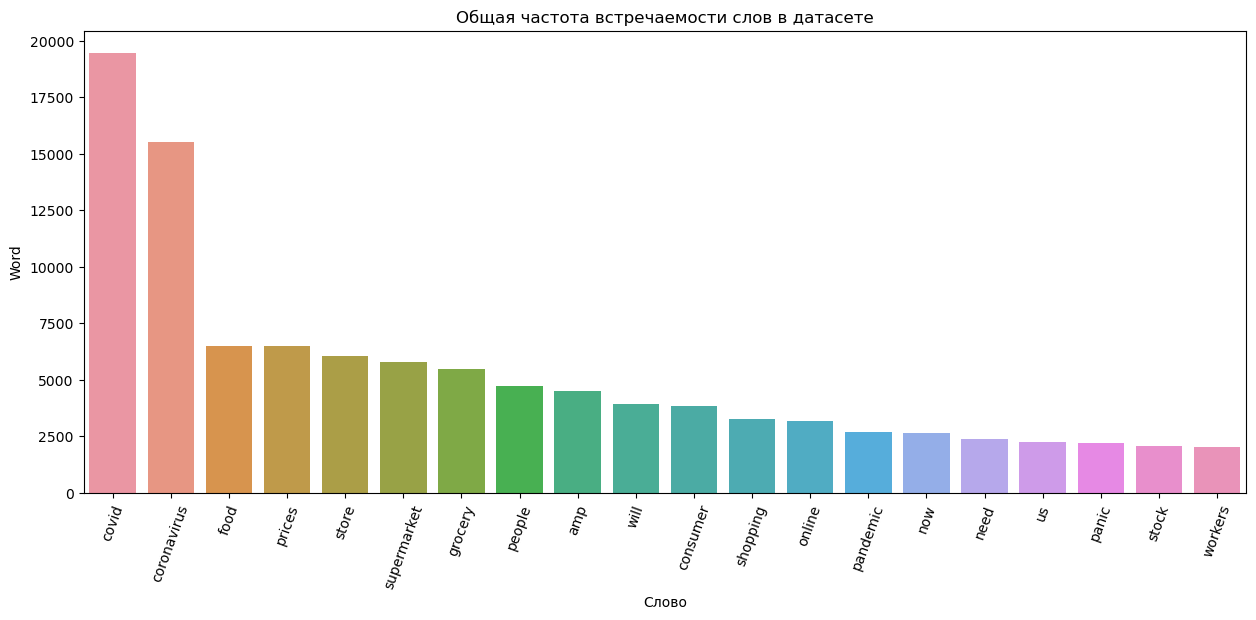

In [24]:
all_tweets = []

for twt in df_cleaned_combined['CleanedTweet'].str.split():
    for word in twt:
            all_tweets.append(word)

combined_twt_without_sw= [word for word in all_tweets if not word in STOPWORDS] #удаление стоп слов

combined_words = pd.DataFrame({"Word": combined_twt_without_sw})

combined_words_df = combined_words['Word'].value_counts()
combined_words_df.head(20)

## настройки графика
plt.figure(figsize=(15,6))
plt.title("Общая частота встречаемости слов в датасете")
plt.xticks(rotation=70)
plt.ylabel("Число упоминаний")
plt.xlabel("Слово")

sns.barplot(x=combined_words_df.head(most_common_words).index, y=combined_words_df.head(most_common_words))

Частота встречаемости слов в позитивных твитах

<Axes: title={'center': 'Частота встречаемости слов в позитивных твитах'}, ylabel='Word'>

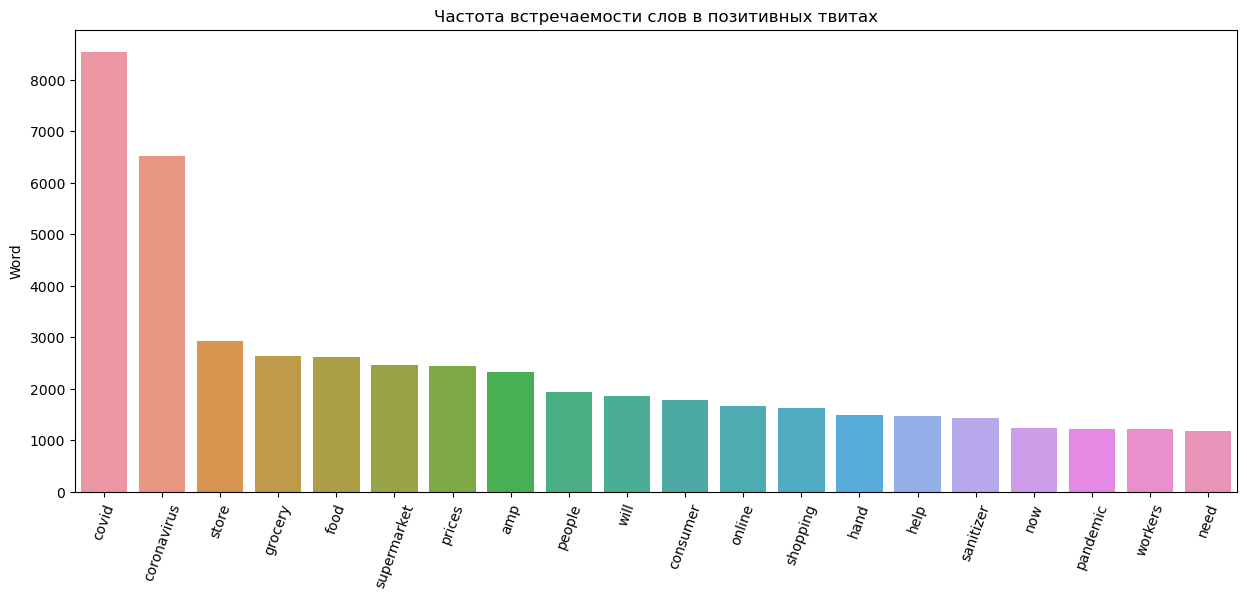

In [25]:
positive_tweets = []

for twt in df_pos['CleanedTweet'].str.split():
    for word in twt:
            positive_tweets.append(word)

pos_twt_without_sw= [word for word in positive_tweets if not word in STOPWORDS] #удаление стоп слов

positive_words = pd.DataFrame({"Word": pos_twt_without_sw})

positive_words_df = positive_words['Word'].value_counts()

## настройки графика
plt.figure(figsize=(15,6))
plt.title("Частота встречаемости слов в позитивных твитах")
plt.xticks(rotation=70)
plt.xlabel("")

sns.barplot(x = positive_words_df.head(most_common_words).index, y = positive_words_df.head(most_common_words))

Частота втречаемости слов в негативных твитах

<Axes: title={'center': 'Частота встречаемости слов в негативных твитах'}, ylabel='Word'>

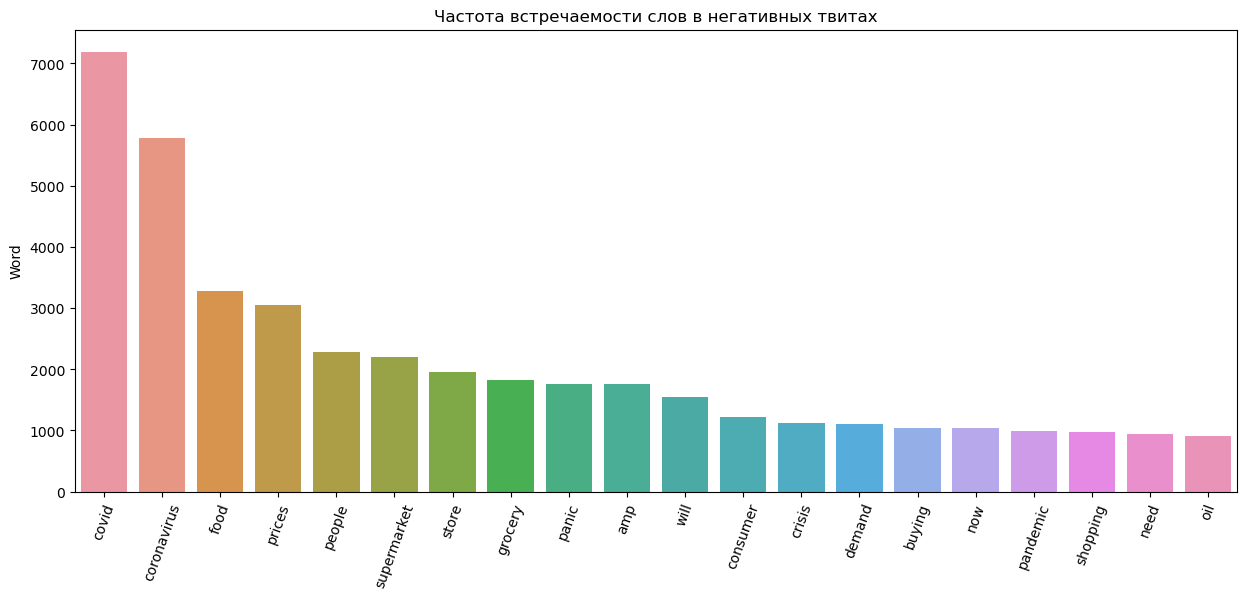

In [26]:
negative_tweets = []

for twt in df_neg['CleanedTweet'].str.split():
    for word in twt:
            negative_tweets.append(word)

neg_twt_without_sw= [word for word in negative_tweets if not word in STOPWORDS] #удаление стоп слов

negative_words = pd.DataFrame({"Word": neg_twt_without_sw})

negative_words_df = negative_words['Word'].value_counts()

## настройки графика
plt.figure(figsize=(15,6))
plt.title("Частота встречаемости слов в негативных твитах")
plt.xticks(rotation=70)
plt.xlabel("")

sns.barplot(x = negative_words_df.head(most_common_words).index, y = negative_words_df.head(most_common_words))

Частота втречаемости слов в нейтральных твитах

<Axes: title={'center': 'Частота встречаемости слов в нейтральных твитах'}, xlabel='Слово', ylabel='Word'>

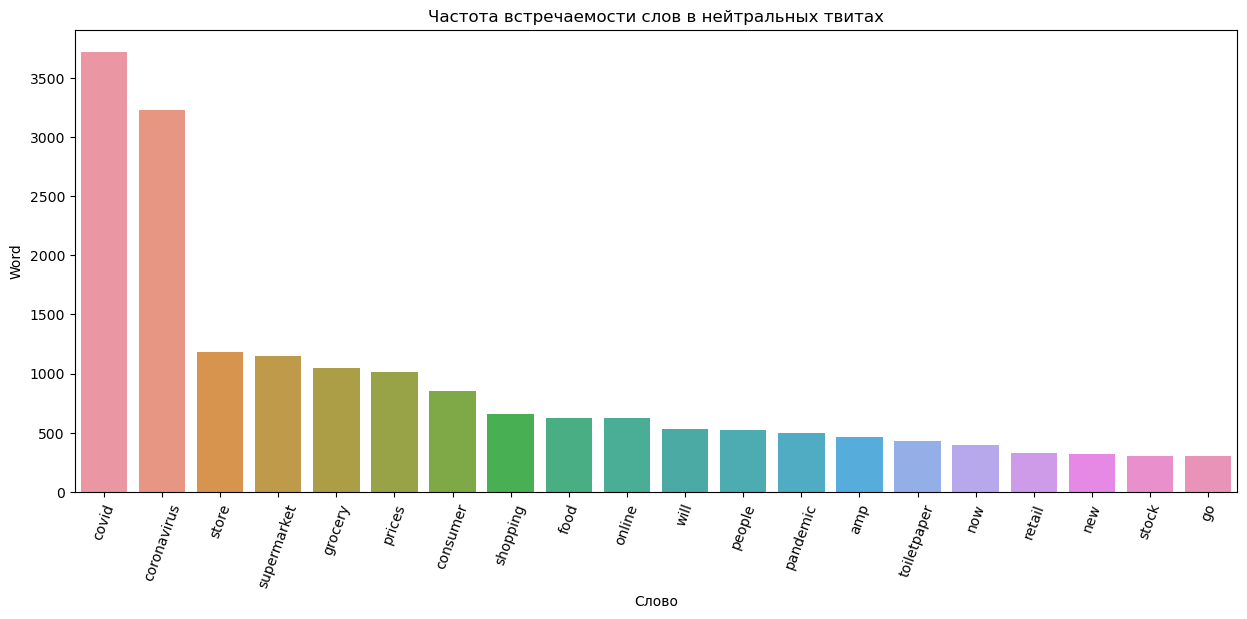

In [27]:
neutral_tweets = []

for twt in df_neu['CleanedTweet'].str.split():
    for word in twt:
            neutral_tweets.append(word)

neu_twt_without_sw= [word for word in neutral_tweets if not word in STOPWORDS] #удаление стоп слов

neutral_words = pd.DataFrame({"Word": neu_twt_without_sw})

neutral_words_df = neutral_words['Word'].value_counts()

## настройки графика
plt.figure(figsize=(15,6))
plt.title("Частота встречаемости слов в нейтральных твитах")
plt.xticks(rotation=70)
plt.xlabel("Слово")

sns.barplot(x = neutral_words_df.head(most_common_words).index, y = neutral_words_df.head(most_common_words))

Как видим из графиков, наиболее часто втречающимся словами, вне зависимости от эмоциональной окраски твита, я вляются слова covid и coronavirus. Далее слова уже различаются. Так в негативных твитах о ценах, кризисе, панике. В нейтральных же и позитивных твитах чаще встречаются такие слова как магазин, супермакерт и тд, что в целом соответствует той эмоциональной окраске, которой размечен данный датасет. Однако при этом в твитах с положительной и нейтральной эмоциональной окраской часто встречаются одни и те же слова, что может затруднить классификацию твитов.

## Обучение модели

В качестве модели, с помощью которой будет производить классификацию твитов, будем использовать предобученную модель BERT библиотеки HuggingFace. Но перед этим необходимо токенизировать предварительно очищенный текст.

In [28]:
#объявим токенизатор
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [29]:
for txt in df_clean_train['CleanedTweet'].values:
    tokens = tokenizer.encode(txt, max_length=TEXT_MAX_LEN, truncation=True)
    
for txt in df_clean_test['CleanedTweet'].values:
    tokens = tokenizer.encode(txt, max_length=TEXT_MAX_LEN, truncation=True)

Закодируем нашу целевую переменную

In [30]:
#закодируем нашу целевую перемнную для тренировочной выборки
df_clean_train['Sentiment'] = df_clean_train['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

#для тестовой выборки
df_clean_test['Sentiment'] = df_clean_test['Sentiment'].map({'Negative':0,'Neutral':1,'Positive':2})

Выделим данные, на которых будем обучать непосредственно саму модель, но перед этим перемешаем внутри датасета все данные

In [31]:
df_clean_train = df_clean_train.sample(frac=1).reset_index(drop=True)
X = df_clean_train['CleanedTweet'].values
y = df_clean_train['Sentiment'].values


df_clean_test = df_clean_test.sample(frac=1).reset_index(drop=True)
X_test = df_clean_test['CleanedTweet'].values
y_test = df_clean_test['Sentiment'].values

Разбиваем на тренировочную и валидационную выборки

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = RANDOM_STATE)

Закодируем выходную переменную с помощью One-hot encoding

In [33]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [34]:
def tokenize(data,max_len=128) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [35]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_valid)
test_input_ids, test_attention_masks = tokenize(X_test)

Теперь зададим саму бертовскую модель

In [36]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [37]:
def create_model(bert_model, max_len=128):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    #задаем три нейрона на выходе, поскольку предсказывать надо три класса
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings) 
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [38]:
model = create_model(bert_model, 128)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [39]:
with tf.device('/GPU:0'): 
    history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs = 10, batch_size = 16)

Epoch 1/10
1826/1826 [==============================] - 646s 348ms/step - loss: 0.5687 - categorical_accuracy: 0.7727 - val_loss: 0.4044 - val_categorical_accuracy: 0.8537
Epoch 2/10
1826/1826 [==============================] - 627s 344ms/step - loss: 0.3151 - categorical_accuracy: 0.8914 - val_loss: 0.3157 - val_categorical_accuracy: 0.8901
Epoch 3/10
1826/1826 [==============================] - 636s 348ms/step - loss: 0.2113 - categorical_accuracy: 0.9302 - val_loss: 0.3039 - val_categorical_accuracy: 0.9008
Epoch 4/10
1826/1826 [==============================] - 636s 348ms/step - loss: 0.1472 - categorical_accuracy: 0.9524 - val_loss: 0.3196 - val_categorical_accuracy: 0.9058
Epoch 5/10
1826/1826 [==============================] - 636s 348ms/step - loss: 0.1106 - categorical_accuracy: 0.9628 - val_loss: 0.3311 - val_categorical_accuracy: 0.9002
Epoch 6/10
1826/1826 [==============================] - 634s 347ms/step - loss: 0.0839 - categorical_accuracy: 0.9714 - val_loss: 0.3840 - v

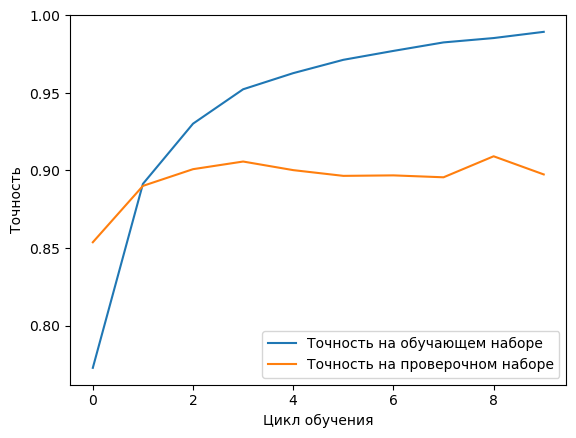

In [45]:
plt.plot(history_bert.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history_bert.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [40]:
result_bert = model.predict([test_input_ids,test_attention_masks])

93/93 [==============================] - 21s 199ms/step


In [47]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [49]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.91      0.86      0.88      1260
     Neutral       0.76      0.81      0.78       494
    Positive       0.88      0.91      0.90      1206

   micro avg       0.87      0.87      0.87      2960
   macro avg       0.85      0.86      0.85      2960
weighted avg       0.87      0.87      0.87      2960
 samples avg       0.87      0.87      0.87      2960



Как видим, наиболее точно были предсказаны твиты c негативной окраской(91% твитов, которые система назвала негативными действительно оказались негативными). При этом наиболее полно предсказаны твиты с позитивной окраской.

Выведем так же матрицу ошибок

In [54]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

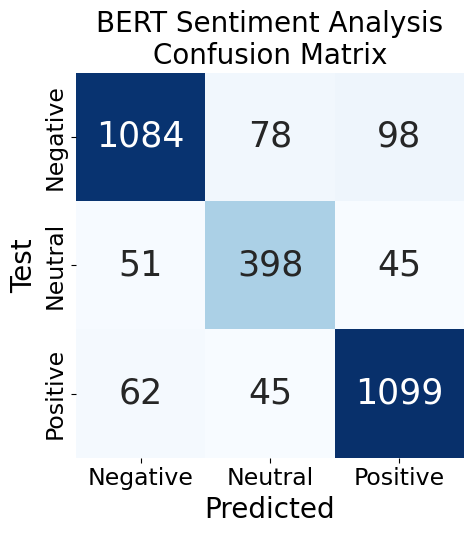

In [55]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

### Вывод:

1) В рамках дипломного проекта был произведен анализ текста твитов: 
    - найдены наиболее часто встречающиеся слова как во всем датасете(тренировочная и тестовая выборка), так и по группам твитов в зависимости по эмоциональной окраске;
    - проанализированы хештеги, упомянутые в твитах аккаунты, а так же местонахождение автора твита, из чего сделан вывод, что большинство пользователей, чьи твиты анализировались в данном датасете, являются гражданами США и Великобритании;
    - проанализирована целевая переменная датасета, в результате чего количество классов целевой переменной уменьшилось с 5 до 3(Extremly Positive был объединен с Positive, Extremly Negative - с Negative).

2) Построена модель BERT для классификации твитов. Данная модель наиболее точно предсказала негативные комментарии(91%), хуже всего - нейтральные комментарии(76%)